In [1]:
wheels_path = "/kaggle/input/clip-interrogator-wheels-x"
clip_interrogator_whl_path = f"{wheels_path}/clip_interrogator-0.4.3-py3-none-any.whl"

In [2]:
!pip install --no-index --find-links $wheels_path $clip_interrogator_whl_path -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*

In [3]:
import inspect
import importlib

from blip.models import blip
from clip_interrogator import clip_interrogator

In [4]:
# replace tokenizer path to prevent downloading
blip_path = inspect.getfile(blip)

fin = open(blip_path, "rt")
data = fin.read()
data = data.replace(
    "BertTokenizer.from_pretrained('bert-base-uncased')", 
    "BertTokenizer.from_pretrained('/kaggle/input/clip-interrogator-models-x/bert-base-uncased')"
)
fin.close()

fin = open(blip_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(blip)

<module 'blip.models.blip' from '/opt/conda/lib/python3.7/site-packages/blip/models/blip.py'>

In [5]:
# fix clip_interrogator bug
clip_interrogator_path = inspect.getfile(clip_interrogator.Interrogator)

fin = open(clip_interrogator_path, "rt")
data = fin.read()
data = data.replace(
    'open_clip.get_tokenizer(clip_model_name)', 
    'open_clip.get_tokenizer(config.clip_model_name.split("/", 2)[0])'
)
fin.close()

fin = open(clip_interrogator_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(clip_interrogator)

<module 'clip_interrogator.clip_interrogator' from '/opt/conda/lib/python3.7/site-packages/clip_interrogator/clip_interrogator.py'>

In [6]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import torch
import open_clip


sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

In [7]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    blip_model_path = "/kaggle/input/clip-interrogator-models-x/model_large_caption.pth"
    ci_clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
    clip_model_name = "ViT-H-14"
    clip_model_path = "/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/open_clip_pytorch_model.bin"
    cache_path = "/kaggle/input/clip-interrogator-models-x"

In [8]:
df_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
df_submission.head()

val
imgId_eId            
20057f34d_0  0.018848
20057f34d_1  0.030190
20057f34d_2  0.072792
20057f34d_3 -0.000673
20057f34d_4  0.016774

In [9]:
images = os.listdir(comp_path / 'images')
imgIds = [i.split('.')[0] for i in images]

eIds = list(range(CFG.embedding_length))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, CFG.embedding_length),
        np.tile(range(CFG.embedding_length), len(imgIds))
    )
]

assert sorted(imgId_eId) == sorted(df_submission.index)

In [10]:
st_model = SentenceTransformer(CFG.sentence_model_path)

In [11]:
model_config = clip_interrogator.Config(clip_model_name=CFG.ci_clip_model_name)
model_config.cache_path = CFG.cache_path

In [12]:
configs_path = os.path.join(os.path.dirname(os.path.dirname(blip_path)), 'configs')
med_config = os.path.join(configs_path, 'med_config.json')
blip_model = blip.blip_decoder(
    pretrained=CFG.blip_model_path,
    image_size=model_config.blip_image_eval_size, 
    vit=model_config.blip_model_type, 
    med_config=med_config
)
blip_model.eval()
blip_model = blip_model.to(model_config.device)
model_config.blip_model = blip_model

load checkpoint from /kaggle/input/clip-interrogator-models-x/model_large_caption.pth


In [13]:
clip_model = open_clip.create_model(CFG.clip_model_name, precision='fp16' if model_config.device == 'cuda' else 'fp32')
open_clip.load_checkpoint(clip_model, CFG.clip_model_path)
clip_model.to(model_config.device).eval()
model_config.clip_model = clip_model

In [14]:
clip_preprocess = open_clip.image_transform(
    clip_model.visual.image_size,
    is_train = False,
    mean = getattr(clip_model.visual, 'image_mean', None),
    std = getattr(clip_model.visual, 'image_std', None),
)
model_config.clip_preprocess = clip_preprocess

In [15]:
ci = clip_interrogator.Interrogator(model_config)

Loaded CLIP model and data in 2.72 seconds.


In [16]:
cos = torch.nn.CosineSimilarity(dim=1)

mediums_features_array = torch.stack([torch.from_numpy(t) for t in ci.mediums.embeds]).to(ci.device)
movements_features_array = torch.stack([torch.from_numpy(t) for t in ci.movements.embeds]).to(ci.device)
flavors_features_array = torch.stack([torch.from_numpy(t) for t in ci.flavors.embeds]).to(ci.device)

In [17]:
def interrogate(image: Image) -> str:
    caption = ci.generate_caption(image)
    image_features = ci.image_to_features(image)
    
    medium = [ci.mediums.labels[i] for i in cos(image_features, mediums_features_array).topk(1).indices][0]
    movement = [ci.movements.labels[i] for i in cos(image_features, movements_features_array).topk(1).indices][0]
    flaves = ", ".join([ci.flavors.labels[i] for i in cos(image_features, flavors_features_array).topk(3).indices])

    if caption.startswith(medium):
        prompt = f"{caption}, {movement}, {flaves}"
    else:
        prompt = f"{caption}, {medium}, {movement}, {flaves}"

    return clip_interrogator._truncate_to_fit(prompt, ci.tokenize)

In [18]:
prompts = []
img_path = "/kaggle/input/seal-img-2/"
images_path = "../input/stable-diffusion-image-to-prompts/images/"
for image_name in images:
    img = Image.open(images_path + image_name).convert("RGB")

    generated = interrogate(img)
    
    prompts.append(generated)
    
img = Image.open(img_path + "seal_image.jpeg").convert("RGB")
generated = interrogate(img)
prompt_seal = generated

In [19]:
def add_text_limiters(text: str) -> str:
    return " ".join([
        word + "\n" if i % 15 == 0 else word 
        for i, word in enumerate(text.split(" "), start=1)
    ])

def plot_image(image: np.ndarray, original_prompt: str, generated_prompt: str) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.annotate(
        "Original prompt:\n" + add_text_limiters(original_prompt) + "\n\nGenerated prompt:\n" + add_text_limiters(generated_prompt), 
        xy=(1.05, 0.5), xycoords='axes fraction', ha='left', va='center', 
        fontsize=16, rotation=0, color="#104a6e"
    )

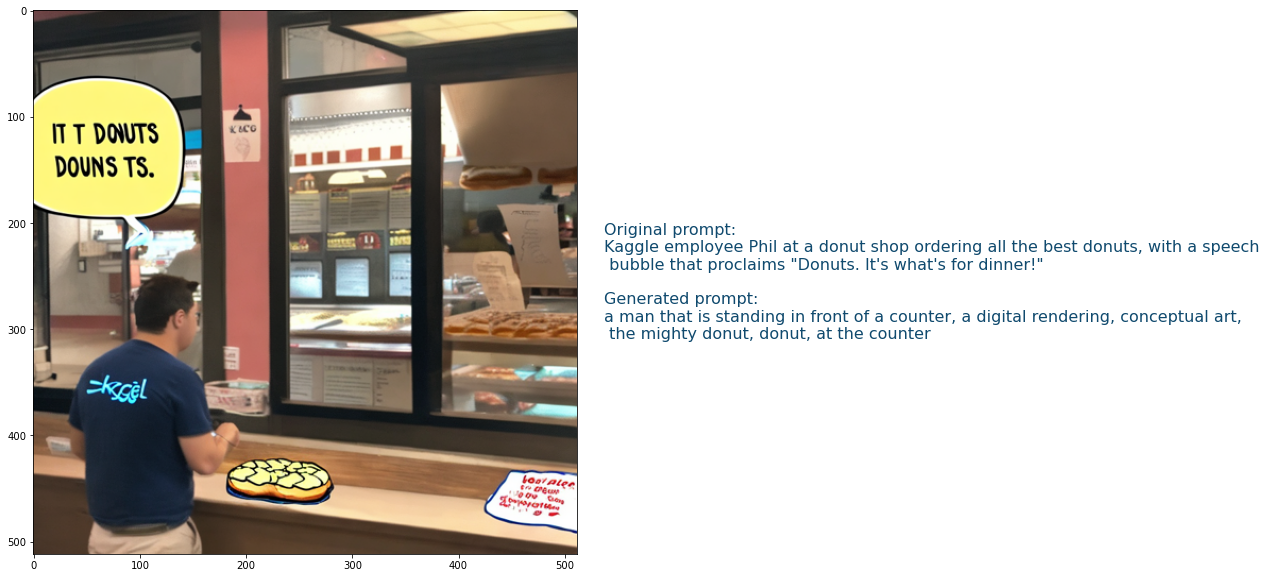

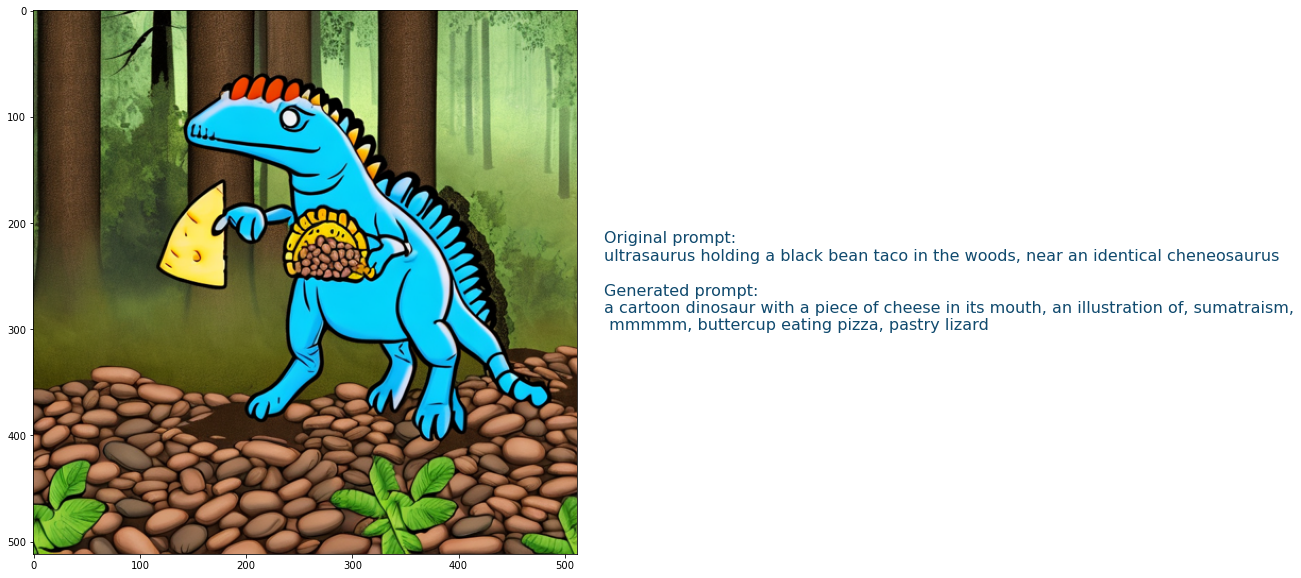

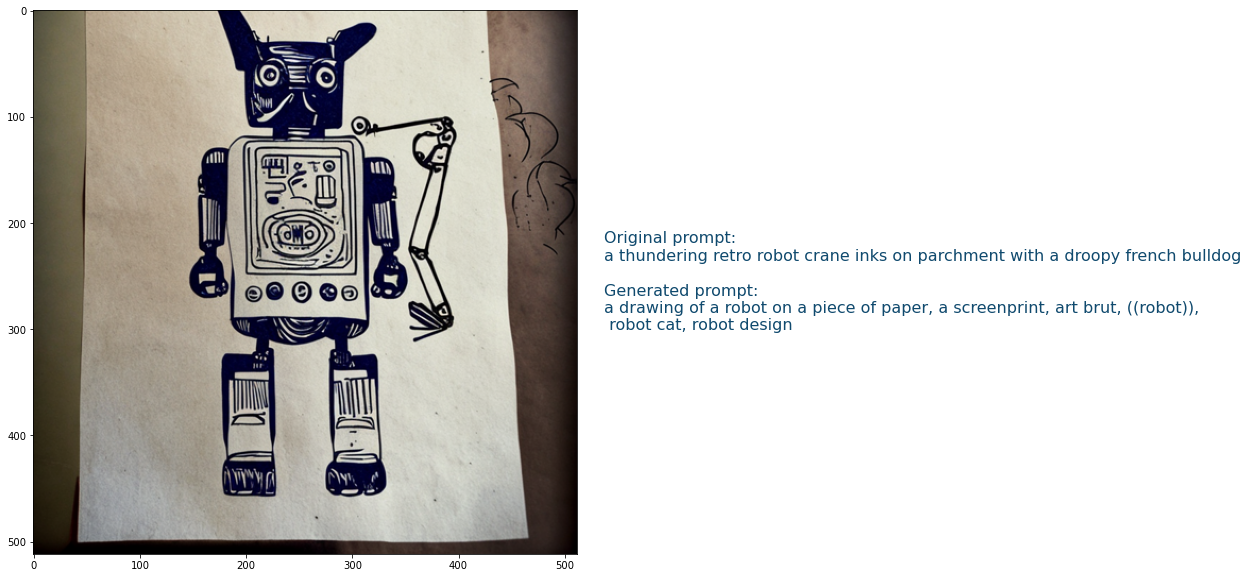

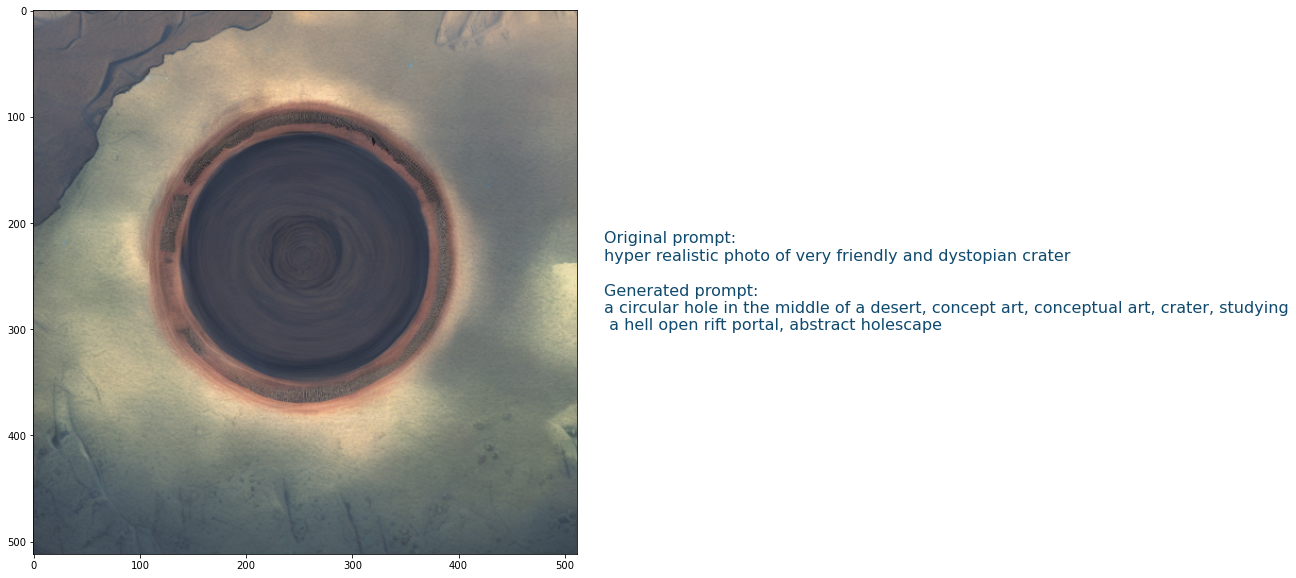

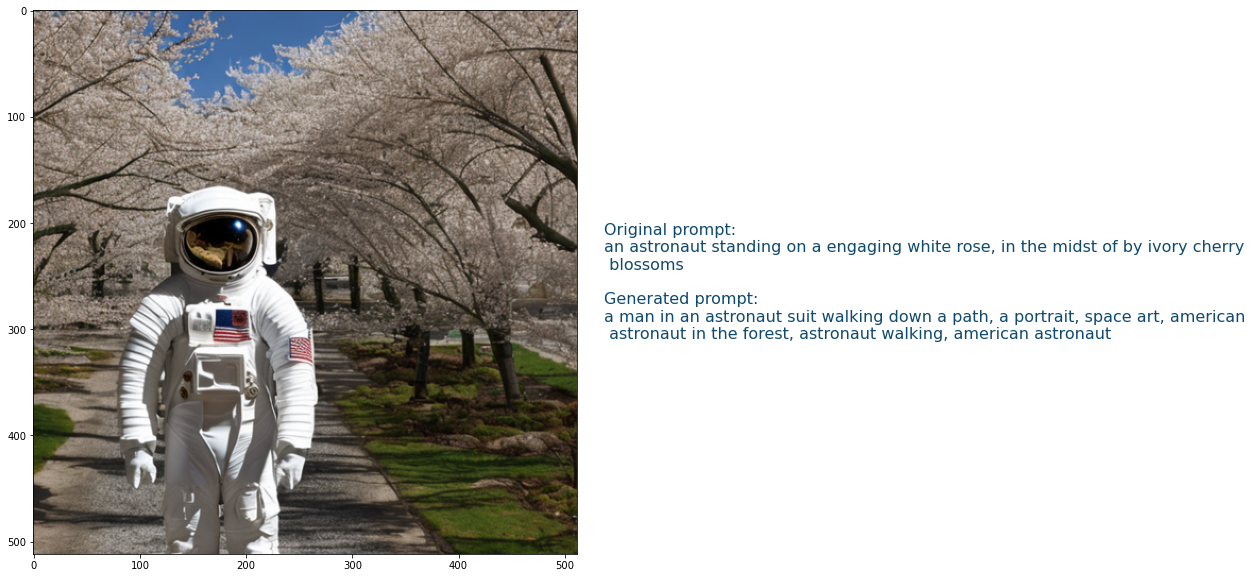

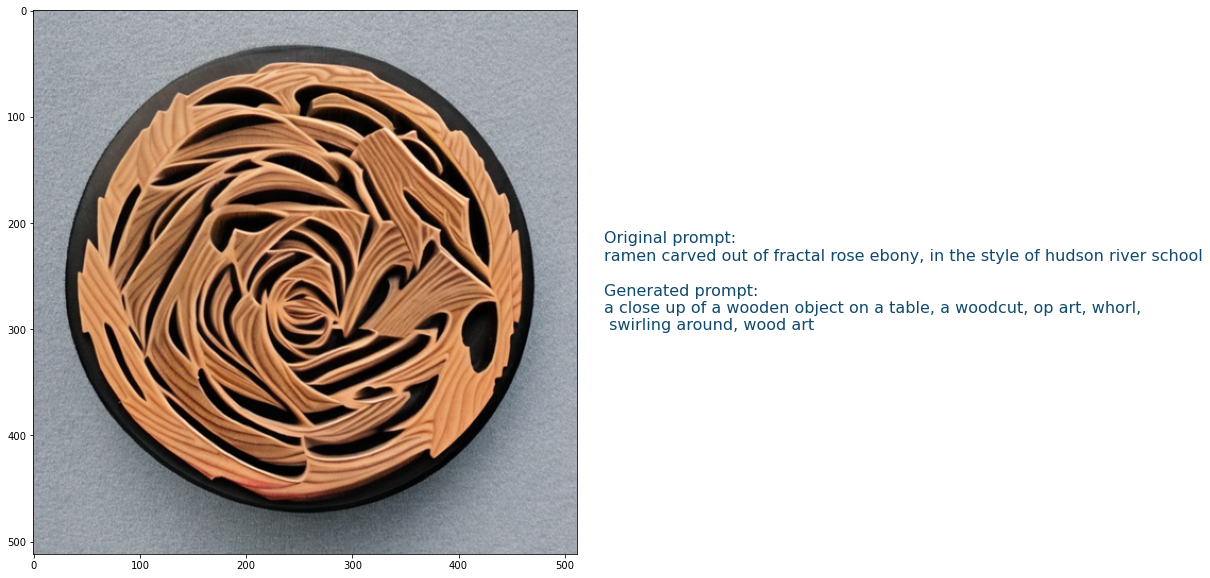

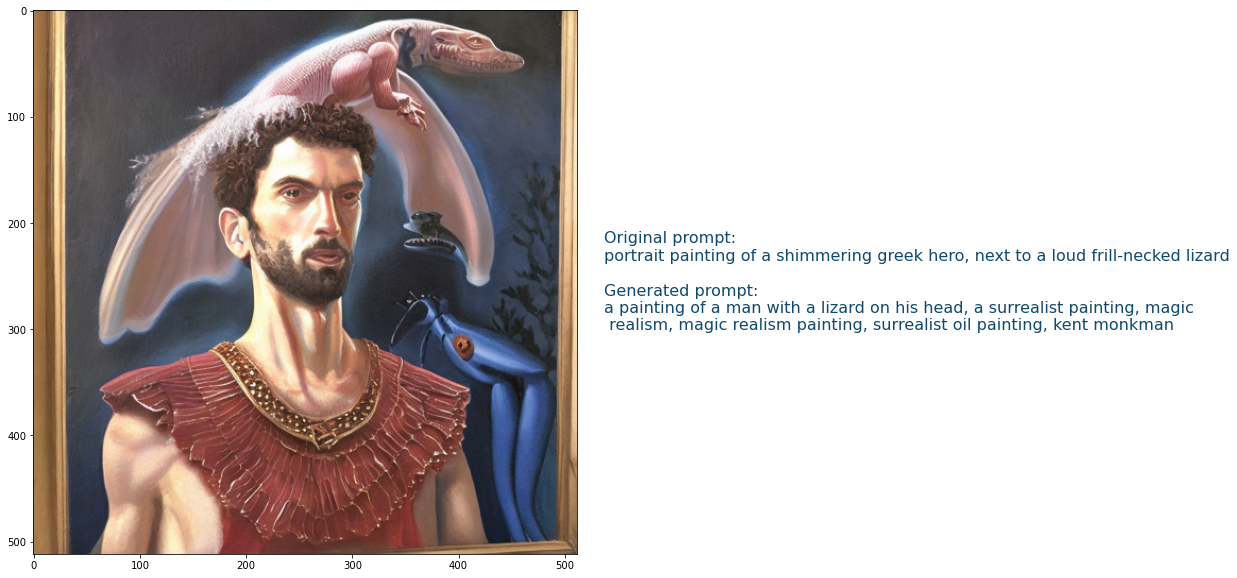

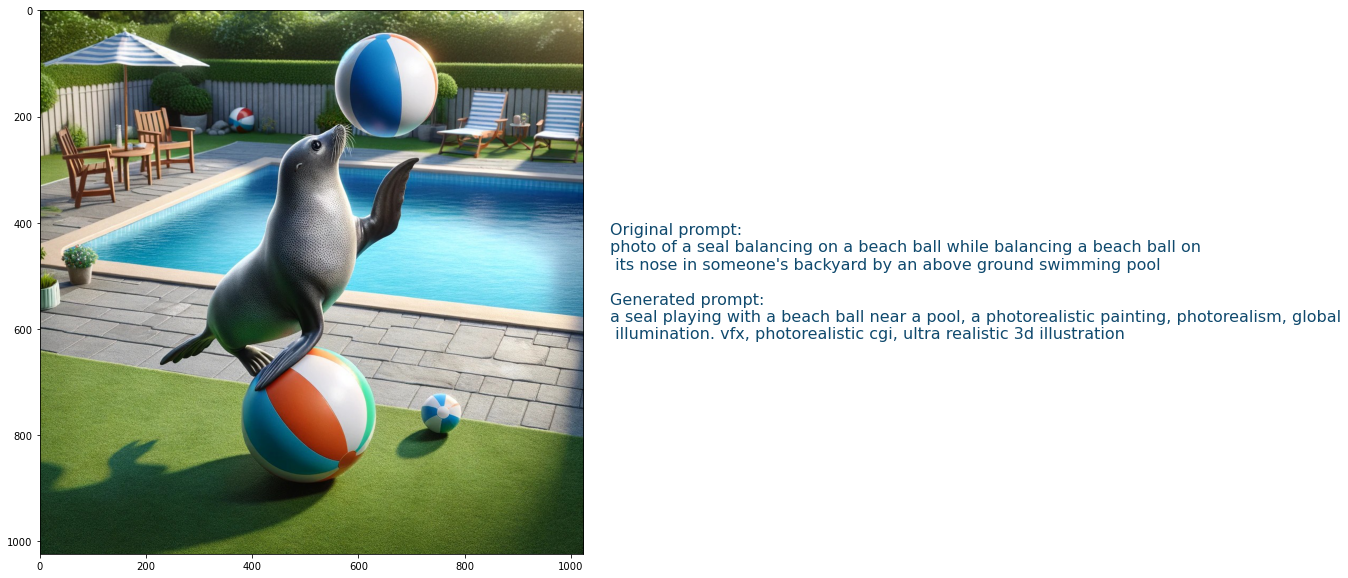

In [20]:
# DO NOT FORGET TO COMMENT OUT THIS CELL DURING SUBMISSION
original_prompts_df = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")

for image_name, prompt in zip(images, prompts):
    img = Image.open(images_path + image_name).convert("RGB")
    original_prompt = original_prompts_df[
        original_prompts_df.imgId == image_name.split(".")[0]
    ].prompt.iloc[0]
    plot_image(img, original_prompt, prompt)
reference_text = "photo of a seal balancing on a beach ball while balancing a beach ball on its nose in someone's backyard by an above ground swimming pool"
img = Image.open(img_path + "seal_image.jpeg").convert("RGB")
plot_image(img, reference_text, prompt_seal)

In [21]:
prompt_embeddings = st_model.encode(prompts).flatten()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=prompt_embeddings,
    columns=['val']
).rename_axis('imgId_eId')

In [23]:
submission.to_csv('submission.csv')